# Optimizing the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Reproduce preprocessed DataFrame

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df = application_df.drop(["EIN", "NAME"], axis=1)
df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Look at APPLICATION_TYPE value counts for binning
bins = df["APPLICATION_TYPE"].value_counts()

# Choose a cutoff value (200) and create a list of application types to be replaced
application_types_to_replace = bins[bins<200].index

# Replace in dataframe
for app in application_types_to_replace:
    df['APPLICATION_TYPE'] = df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: count, dtype: int64

In [4]:
# Look at CLASSIFICATION value counts for binning
bins = df["CLASSIFICATION"].value_counts()

# Choose a cutoff value and create a list of classifications to be replaced
classifications_to_replace = bins[bins<1500].index

# Replace in dataframe
for cls in classifications_to_replace:
    df['CLASSIFICATION'] = df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: count, dtype: int64

In [5]:
# Convert categorical data to numeric with `pd.get_dummies`
# SPECIAL_CONSIDERATIONS_N is dropped because the original column is just a binary Yes/No column and can simply be represented in 1/0 format
dummy_df = pd.get_dummies(df.select_dtypes(exclude="int64"), dtype="float").drop("SPECIAL_CONSIDERATIONS_N", axis=1)

# According to some online sources, it doesn't make sense to scale the dummy or binary variables
# (They're all on the scale of 0-1)
# So I'll only be scaling the numerical values, which only one column has

# Split our preprocessed data into our features and target arrays
y = df.loc[:, ["IS_SUCCESSFUL"]]
scaleMe = df.loc[:, ["ASK_AMT"]]

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler and scale the data
scaler.fit(scaleMe)
scaled_data = scaler.transform(scaleMe)

# Combine data
scaled_df = pd.DataFrame(scaled_data)
X = pd.concat([dummy_df, scaled_df, df.loc[:, ["STATUS"]]], axis=1).rename(columns={0:"ASK_AMT"})

# Split the preprocessed data into a training and testing dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X,y)

In [6]:
len(X.columns)

42

### Hyperparameter Tuning

In [7]:
import keras_tuner as kt
input_features = len(X.columns)

# The following parameters are chosen because running it indiscriminately yields no progress after 14 hours.
# Large steps are taken for the sake of time.
def create_model(hp):
    model = tf.keras.models.Sequential()
    
    # Define what activation functions to choose from
    activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    
    # Define neurons to optimize for the input layer
    model.add(tf.keras.layers.Dense(units=hp.Int("first_units", min_value=input_features, max_value=2*input_features, step=10),
                                   activation=activation, input_dim=input_features))
    
    # Optimize number of hidden layers and neurons for each
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int("units_"+str(i), min_value=input_features, max_value=2*input_features, step=10),
                                       activation=activation))
    
    # Output layer stays the same
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

Using TensorFlow backend


In [8]:
# Define tuner
tuner = kt.Hyperband(create_model, objective="val_accuracy", max_epochs=200, hyperband_iterations=1)

# Run tuner
tuner.search(X_train_scaled, y_train, epochs=200, validation_data=(X_test_scaled, y_test))

Trial 254 Complete [00h 04m 05s]
val_accuracy: 0.732478141784668

Best val_accuracy So Far: 0.7337609529495239
Total elapsed time: 01h 51m 42s


In [9]:
# Unfortunately, somehow, even after messing around with hyperparameters, the validation accuracy still only hovers around 73%
best_hp = tuner.get_best_hyperparameters(1)[0]
best_hp.values

{'activation': 'tanh',
 'first_units': 82,
 'num_layers': 3,
 'units_0': 42,
 'units_1': 72,
 'units_2': 82,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0236'}

In [10]:
# Evaluate the new "optimized" model using the test data
best_model = tuner.get_best_models(1)[0]

model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5537 - accuracy: 0.7338 - 402ms/epoch - 1ms/step
Loss: 0.5536605715751648, Accuracy: 0.7337609529495239


In [11]:
# Export our model to HDF5 file
best_model.save("AlphabetSoupCharity_Optimization.h5")

C:\Users\user\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Just a quick test: Logistical Regression

In [13]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model. A random_state of 1 is assigned to the function for reproducibility
model = LogisticRegression()

# Fit the model using training data
model.fit(X_train_scaled, y_train)

C:\Users\user\anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
# Make a prediction using the testing data
predictions = model.predict(X_test_scaled)

Balanced Accuracy Score: 0.7223023631320025
--------
              precision    recall  f1-score   support

           0       0.72      0.67      0.70      4054
           1       0.73      0.77      0.75      4521

    accuracy                           0.72      8575
   macro avg       0.72      0.72      0.72      8575
weighted avg       0.72      0.72      0.72      8575



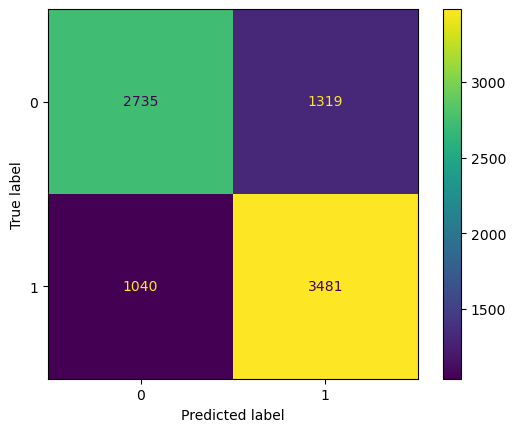

In [19]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, predictions)}")
print("--------")
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()